In [1]:
import os
from tqdm.notebook import tqdm
import random
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable TF Warnings
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["tf_gpu_allocator"]="cuda_malloc_async"
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Fri Oct 27 10:37:41 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.43.02              Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070        On  | 00000000:01:00.0  On |                  N/A |
|  0%   36C    P8               8W / 200W |   1417MiB / 12282MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
import cv2

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

from sklearn.utils.class_weight import compute_class_weight

In [9]:
sns.set(style='darkgrid', palette='deep')

tf.random.set_seed(42)

# Exploratory Data Analysis

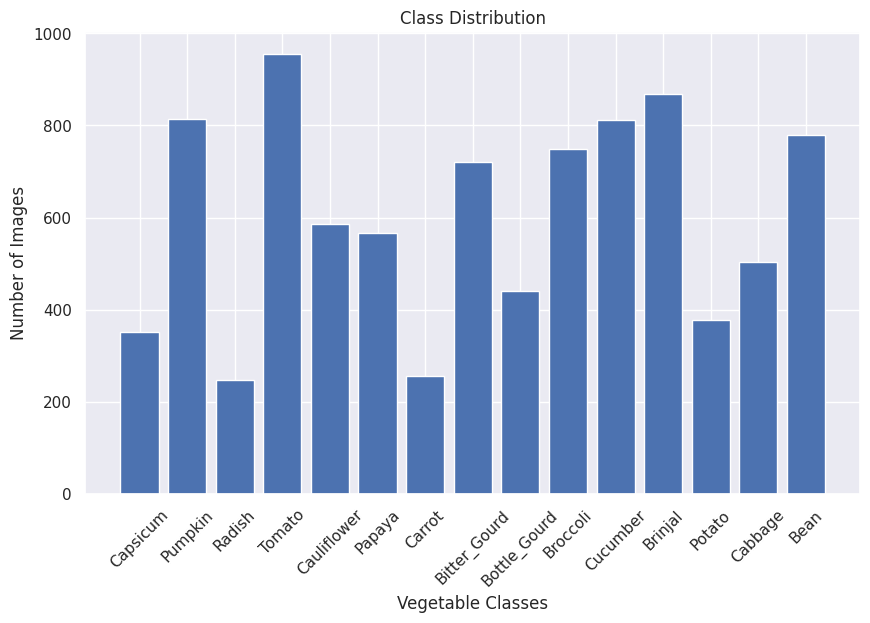

In [10]:
# Count the number of images in each class
class_counts = {}
for subdir, _, files in os.walk('Vegetable Images/train/'):
    if subdir.split("/")[-1] != "":
        class_counts[subdir.split("/")[-1]] = len(files)

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Vegetable Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

* Imbalanced Dataset
* Will have to via adjusting class weights, penalising the model more for incorrect classification of lower frequency class

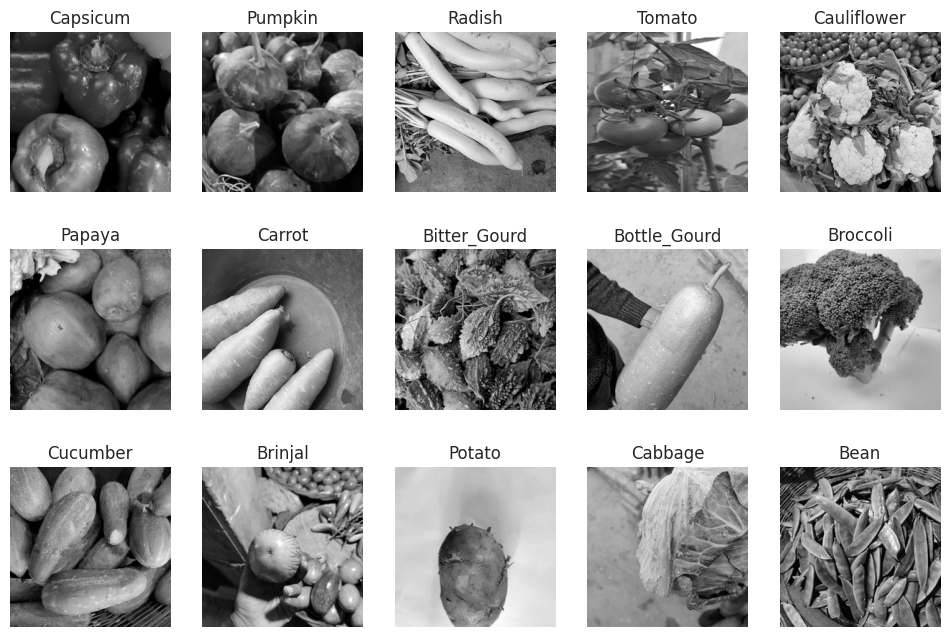

In [11]:
plt.figure(figsize=(12, 8))
for i in range(15):
    subdir = os.listdir('Vegetable Images/train/')[i]
    img_file = random.choice(os.listdir(os.path.join('Vegetable Images/train/', subdir)))
    img_path = os.path.join('Vegetable Images/train', subdir, img_file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(3, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(subdir)
    plt.axis('off')
plt.show()

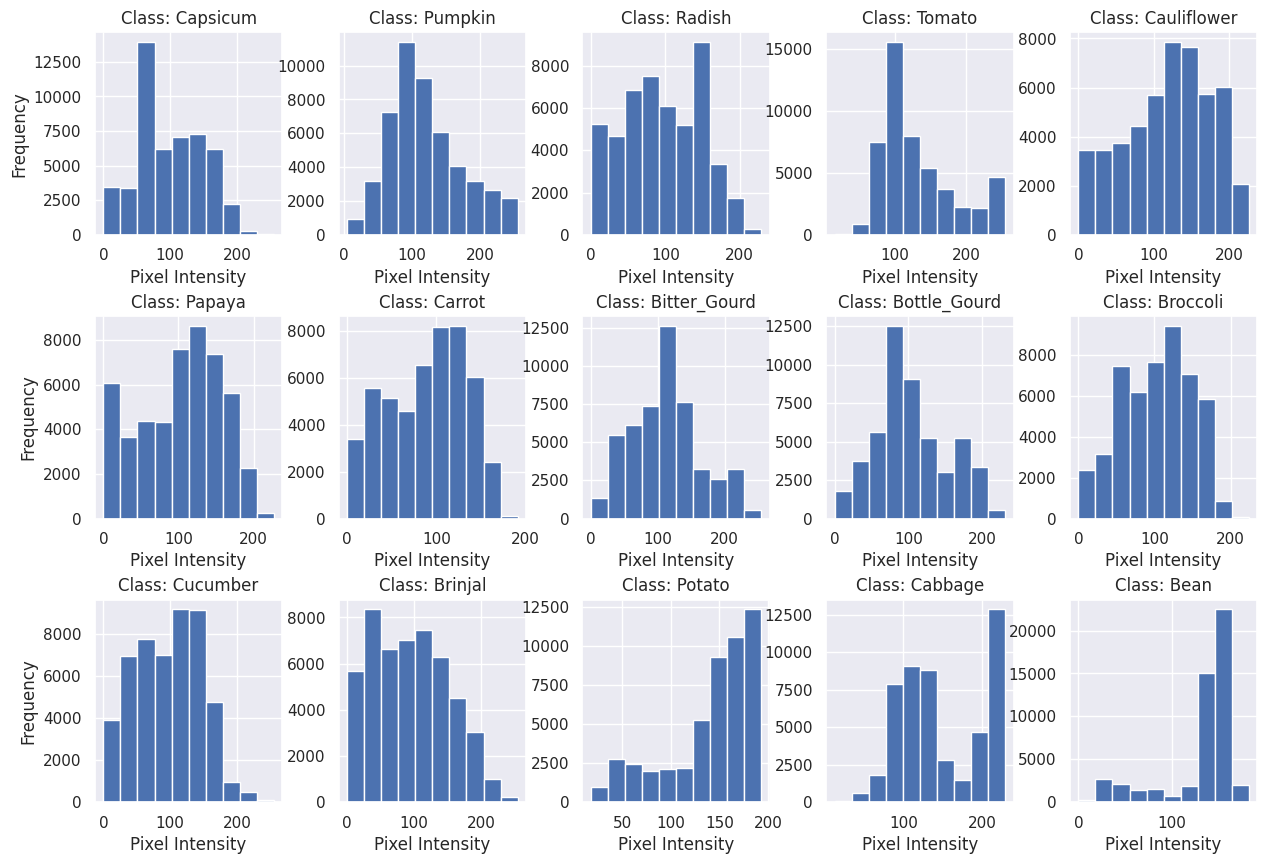

In [12]:
def plot_intensity_histogram(image_path, class_name, ax):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    ax.hist(img.ravel())
    ax.set_xlabel('Pixel Intensity')
    ax.set_title(f'Class: {class_name}')
    return ax

fig, axes = plt.subplots(3, 5, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

class_folders = os.listdir('Vegetable Images/train/')
for i, class_folder in enumerate(class_folders):
    sample_image_path = os.path.join('Vegetable Images/train/', class_folder, os.listdir(f'Vegetable Images/train/{class_folder}')[0])
    row = i // 5
    col = i % 5
    ax = plot_intensity_histogram(sample_image_path, class_folder, axes[row, col])
    if col == 0:
        ax.set_ylabel('Frequency')

plt.show()

In [13]:
class_keys = {
    "Bean": 0,
    "Bitter_Gourd": 1,
    "Bottle_Gourd": 2,
    "Brinjal": 3,
    "Broccoli": 4,
    "Cabbage": 5,
    "Capsicum": 6,
    "Carrot": 7,
    "Cauliflower": 8,
    "Cucumber": 9,
    "Papaya": 10,
    "Potato": 11,
    "Pumpkin": 12,
    "Radish": 13,
    "Tomato": 14
}

In [14]:
def load_images(folder_path, image_size):
    images = []
    labels = []
    counter = 0
    for subdir, _, files in os.walk(folder_path):
        for file in tqdm(files, desc=subdir):
            img_path = os.path.join(subdir, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img.shape != (image_size, image_size):
                img = cv2.resize(img, (image_size, image_size))
            images.append(img)
            labels.append(class_keys[subdir.split("/")[-1]])
            counter += 1
    
    images = np.array(images).reshape(-1, image_size, image_size, 1)
    return images, to_categorical(np.array(labels), 15)

# def resize_images(image_arr, image_size):
#     image_arr = [cv2.resize(img, (image_size, image_size)) for img in image_arr]
#     return np.array(image_arr).reshape(-1, image_size, image_size, 1)

train_images, train_labels = load_images('Vegetable Images/train/', 224)
test_images, test_labels = load_images('Vegetable Images/test/', 224)
val_images, val_labels = load_images('Vegetable Images/validation/', 224)

# small_train_images = resize_images(train_images, 31)
# small_test_images = resize_images(test_images, 31)
# small_val_images = resize_images(val_images, 31)


Vegetable Images/train/: 0it [00:00, ?it/s]

Vegetable Images/train/Capsicum:   0%|          | 0/351 [00:00<?, ?it/s]

Vegetable Images/train/Pumpkin:   0%|          | 0/814 [00:00<?, ?it/s]

Vegetable Images/train/Radish:   0%|          | 0/248 [00:00<?, ?it/s]

Vegetable Images/train/Tomato:   0%|          | 0/955 [00:00<?, ?it/s]

Vegetable Images/train/Cauliflower:   0%|          | 0/587 [00:00<?, ?it/s]

Vegetable Images/train/Papaya:   0%|          | 0/566 [00:00<?, ?it/s]

Vegetable Images/train/Carrot:   0%|          | 0/256 [00:00<?, ?it/s]

Vegetable Images/train/Bitter_Gourd:   0%|          | 0/720 [00:00<?, ?it/s]

Vegetable Images/train/Bottle_Gourd:   0%|          | 0/441 [00:00<?, ?it/s]

Vegetable Images/train/Broccoli:   0%|          | 0/750 [00:00<?, ?it/s]

Vegetable Images/train/Cucumber:   0%|          | 0/812 [00:00<?, ?it/s]

Vegetable Images/train/Brinjal:   0%|          | 0/868 [00:00<?, ?it/s]

Vegetable Images/train/Potato:   0%|          | 0/377 [00:00<?, ?it/s]

Vegetable Images/train/Cabbage:   0%|          | 0/503 [00:00<?, ?it/s]

Vegetable Images/train/Bean:   0%|          | 0/780 [00:00<?, ?it/s]

Vegetable Images/test/: 0it [00:00, ?it/s]

Vegetable Images/test/Capsicum:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Pumpkin:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Radish:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Tomato:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Cauliflower:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Papaya:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Carrot:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Bitter_Gourd:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Bottle_Gourd:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Broccoli:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Cucumber:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Brinjal:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Potato:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Cabbage:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Bean:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/: 0it [00:00, ?it/s]

Vegetable Images/validation/Capsicum:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Pumpkin:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Radish:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Tomato:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Cauliflower:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Papaya:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Carrot:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Bitter_Gourd:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Bottle_Gourd:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Broccoli:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Cucumber:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Brinjal:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Potato:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Cabbage:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Bean:   0%|          | 0/200 [00:00<?, ?it/s]

## Preprocessing: Data Augmentation 
#### Reasoning:
* Data augmentation effectively increases the size of the training dataset. With more diverse examples, the model can learn a broader range of patterns and become more robust. Especially with some classes only having about 200 training samples.
* Model will be more generalized and reduces overfitting from memorizing specific examples.

In [15]:
from keras.layers import RandomCrop, RandomContrast, RandomFlip, RandomRotation, RandomTranslation, RandomZoom, Resizing

# extremely slow in TF 2.10.0, can slow model as much as 6x

# image_augmentation = Sequential(
#     [
#         RandomFlip("horizontal_and_vertical"),
#         RandomContrast(0.5),
#         RandomRotation(1),
#         RandomZoom(0.5, 0.5)
#     ]
# )

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

resize_small = Resizing(31, 31)
resize_large = Resizing(128, 128)

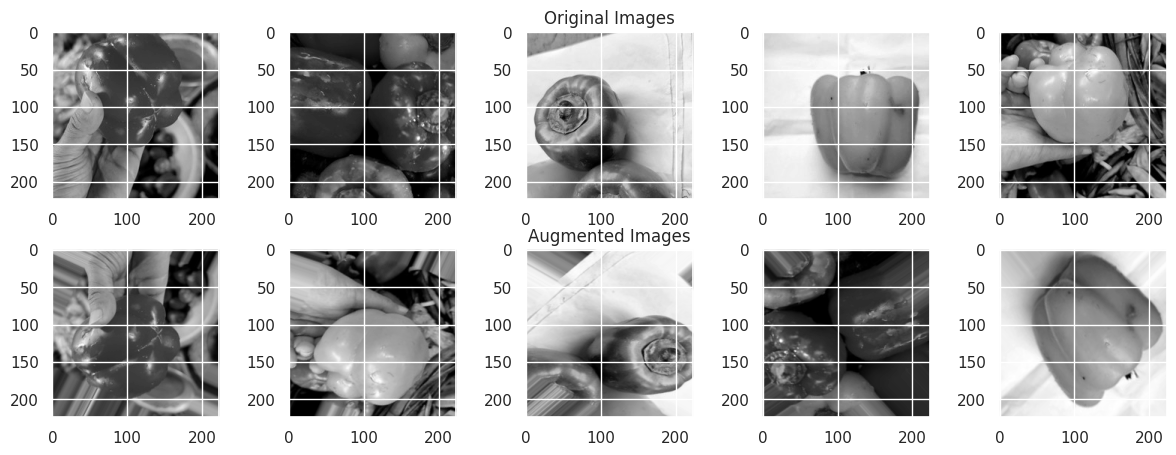

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

# axes = np.flatten(axes)
plt.subplots_adjust(hspace=0.3, wspace=0.1)

augmented = datagen.flow(train_images[:5])

for i in range(5):
    axes[0][i].imshow(train_images[i], cmap="gray")
    axes[1][i].imshow(augmented[0][i], cmap="gray")
    
    
axes[0][2].set_title("Original Images")
axes[1][2].set_title("Augmented Images")
    
plt.show()

This data augmentation is added as a preprocessing layer in the model and applied during model training.

### Calculating Class Weights

In [17]:
class_series = np.argmax(train_labels, axis=1)
class_labels = np.unique(class_series)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
class_weights = dict(zip(class_labels, class_weights))
print(class_weights)

{0: 0.7716239316239316, 1: 0.835925925925926, 2: 1.3647770219198792, 3: 0.693394777265745, 4: 0.8024888888888889, 5: 1.1965540092776674, 6: 1.7147198480531813, 7: 2.3510416666666667, 8: 1.0253265190232823, 9: 0.7412151067323481, 10: 1.0633686690223794, 11: 1.5964633068081344, 12: 0.7393939393939394, 13: 2.4268817204301074, 14: 0.6302268760907505}


Classes with the lowest sample count in the training set will have the greatest weight eg. 13: Radish

## Basic CNN with 
* Image Augmentation Preprocessing Layer

In [ ]:
model_large = Sequential([
    resize_large,
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(15, activation='softmax')
])

# model_large_with_augment = Sequential([
#     datagen,
#     model_large
# ], name="bigboi")

# Compile the model
model_large.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Decrease batch size if kernel dies
# history = model_large.fit(train_images, train_labels, epochs=1, batch_size=1, validation_data=(val_images, val_labels))

batch_size=1
epochs=1

history = model_large.fit_generator(
    datagen.flow(train_images, train_labels, batch_size=batch_size),
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=(val_images, val_labels)
)

# accuracy = model_large.evaluate(test_images, test_labels, verbose=0)[1]

print(f"Accuracy for small images (128x128): {accuracy:.2f}")

In [ ]:
history = model_large.fit_generator(
    datagen.flow(train_images, train_labels, batch_size=batch_size),
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=(val_images, val_labels)
)

In [18]:
tf.keras.backend.clear_session()

In [19]:
!nvidia-smi

Fri Oct 27 10:17:25 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.43.02              Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070        On  | 00000000:01:00.0  On |                  N/A |
|  0%   36C    P8               8W / 200W |  11075MiB / 12282MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [45]:
model_small.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 1)       0         
                                                                 
 resizing_3 (Resizing)       (None, 128, 128, 1)       0         
                                                                 
 conv2d_58 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 conv2d_59 (Conv2D)          (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_60 (Conv2D)          (None, 60, 60, 64)        36928     
                                                     

In [23]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()


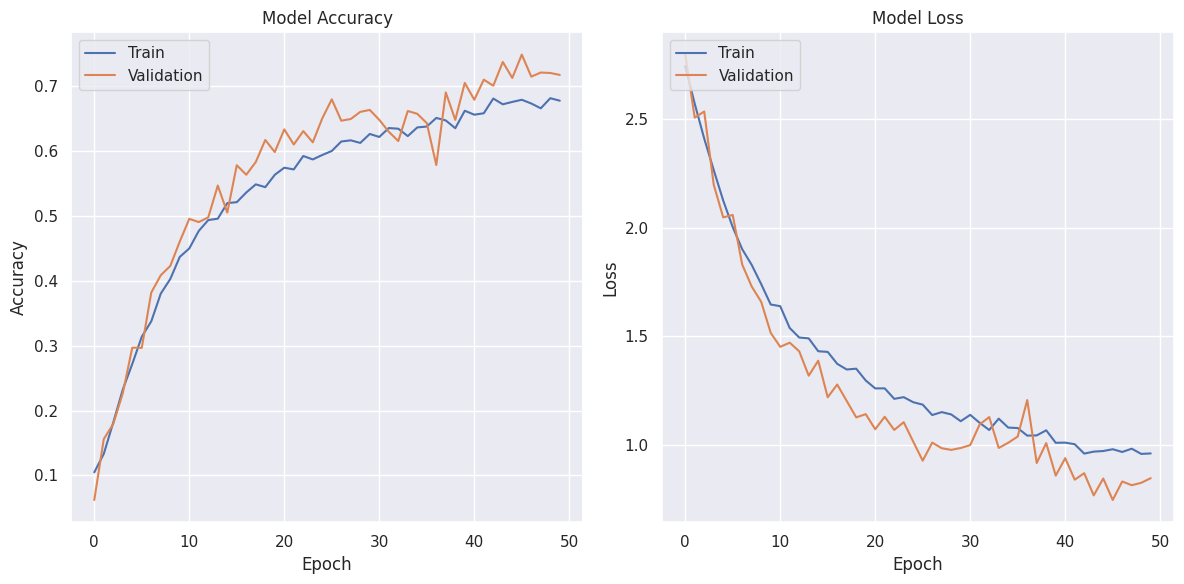

In [24]:
plot_history(history)

## Basic CNN with 
* Image Augmentation Preprocessing Layer
* Learning Rate Scheduling

In [37]:
model_small = Sequential([
    image_augmentation,
    resize_small,
    Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(15, activation='softmax')
])

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000000, decay_rate=0.96, staircase=True)

custom_optimizer = Adam(learning_rate=lr_schedule)
model_small.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model_small.fit(train_images, train_labels, epochs=50, batch_size=50, validation_data=(val_images, val_labels))

small_accuracy = model_small.evaluate(test_images, test_labels, verbose=0)[1]

print(f"Accuracy for small images (31x31): {small_accuracy:.2f}")

Epoch 1/50
181/181 [==============================] - 6s 29ms/step - loss: 2.8756 - accuracy: 0.1155 - val_loss: 2.6745 - val_accuracy: 0.1090
Epoch 2/50
181/181 [==============================] - 5s 29ms/step - loss: 2.5272 - accuracy: 0.1500 - val_loss: 2.6105 - val_accuracy: 0.1567
Epoch 3/50
181/181 [==============================] - 5s 28ms/step - loss: 2.4194 - accuracy: 0.1768 - val_loss: 2.5116 - val_accuracy: 0.1333
Epoch 4/50
181/181 [==============================] - 5s 29ms/step - loss: 2.3232 - accuracy: 0.2196 - val_loss: 2.3938 - val_accuracy: 0.1860
Epoch 5/50
181/181 [==============================] - 5s 27ms/step - loss: 2.2617 - accuracy: 0.2356 - val_loss: 2.3715 - val_accuracy: 0.2120
Epoch 6/50
181/181 [==============================] - 5s 29ms/step - loss: 2.1349 - accuracy: 0.2739 - val_loss: 2.1535 - val_accuracy: 0.2727
Epoch 7/50
181/181 [==============================] - 5s 28ms/step - loss: 2.0587 - accuracy: 0.2962 - val_loss: 2.2234 - val_accuracy: 0.2223

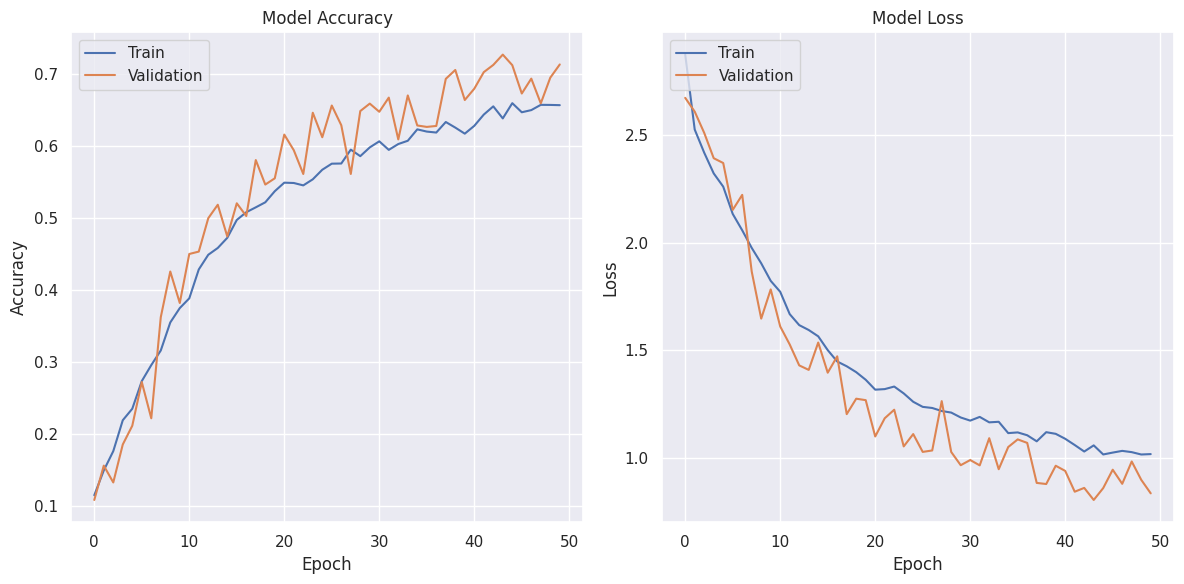

In [39]:
plot_history(history)

## Basic CNN with 
* Image Augmentation Preprocessing Layer
* Learning Rate Scheduling
* LeakyReLU Activation

In [41]:
model_small = Sequential([
    image_augmentation,
    resize_small,
    Conv2D(32, (3, 3), input_shape=(31, 31, 1)),
    LeakyReLU(alpha=0.1),
    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),
    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(400),
    LeakyReLU(alpha=0.1),
    Dense(400),
    LeakyReLU(alpha=0.1),
    Dense(15, activation='softmax')
])

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000000, decay_rate=0.96, staircase=True)

custom_optimizer = Adam(learning_rate=lr_schedule)
model_small.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model_small.fit(train_images, train_labels, epochs=50, batch_size=50, validation_data=(val_images, val_labels))

small_accuracy = model_small.evaluate(test_images, test_labels, verbose=0)[1]

print(f"Accuracy for small images (31x31): {small_accuracy:.2f}")

Epoch 1/50
181/181 [==============================] - 6s 30ms/step - loss: 2.7678 - accuracy: 0.1379 - val_loss: 2.7177 - val_accuracy: 0.1270
Epoch 2/50
181/181 [==============================] - 5s 29ms/step - loss: 2.3865 - accuracy: 0.1865 - val_loss: 2.4109 - val_accuracy: 0.2263
Epoch 3/50
181/181 [==============================] - 5s 28ms/step - loss: 2.2570 - accuracy: 0.2383 - val_loss: 2.1434 - val_accuracy: 0.2737
Epoch 4/50
181/181 [==============================] - 5s 28ms/step - loss: 2.1374 - accuracy: 0.2727 - val_loss: 2.0482 - val_accuracy: 0.2747
Epoch 5/50
181/181 [==============================] - 5s 30ms/step - loss: 2.0181 - accuracy: 0.3137 - val_loss: 1.8278 - val_accuracy: 0.3890
Epoch 6/50
181/181 [==============================] - 5s 29ms/step - loss: 1.9487 - accuracy: 0.3344 - val_loss: 1.8695 - val_accuracy: 0.3407
Epoch 7/50
181/181 [==============================] - 5s 29ms/step - loss: 1.8109 - accuracy: 0.3806 - val_loss: 1.7950 - val_accuracy: 0.3880

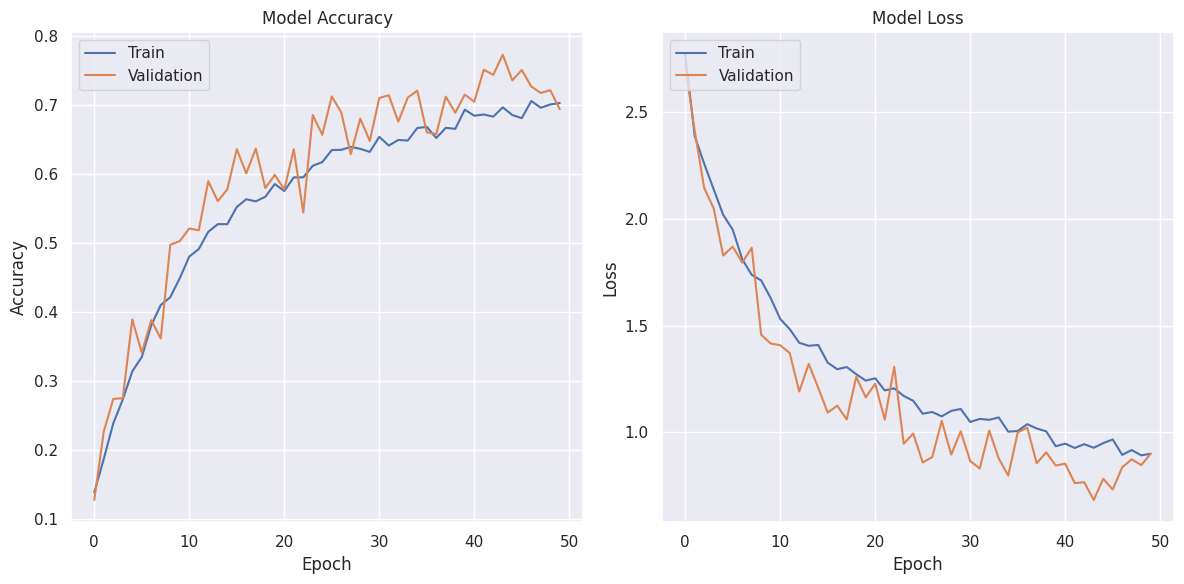

In [42]:
plot_history(history)

The peak validation accuracy has increased with LeakyReLU over ReLU so this seems like an improvement.

In [ ]:
model_small = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1), kernel_regularizer=l2(0.01)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(15, activation='softmax')
])

# Compile the model
model_small.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model for small images
history = model_small.fit(small_train_images, small_train_labels, epochs=10, batch_size=50, validation_data=(small_val_images, small_val_labels))

small_accuracy = model_small.evaluate(small_test_images, small_test_labels, verbose=0)[1]

print(f"Accuracy for small images (31x31): {small_accuracy:.2f}")

history.history

In [ ]:

    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),

In [ ]:
# Create the neural network model for small images
fast_model_small = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(15, activation='softmax')
])

In [414]:
model_small.summary()

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_84 (Sequential)  (None, 224, 224, 1)       0         
                                                                 
 resizing_21 (Resizing)      (None, 31, 31, 1)         0         
                                                                 
 conv2d_100 (Conv2D)         (None, 29, 29, 32)        320       
                                                                 
 conv2d_101 (Conv2D)         (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_102 (Conv2D)         (None, 11, 11, 64)        36928     
                                                     